# Data Preprocessing
## 1. For budget vs revenue

In [1]:
# Data Preprocessing for Predicting Revenue/Budget Ratio

# Import necessary libraries
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler

In [2]:
# Load credits.csv
credits = pd.read_csv('./raw-data/credits.csv')

# Load keywords.csv
keywords = pd.read_csv('./raw-data/keywords.csv')

# Load links.csv
links = pd.read_csv('./raw-data/links.csv')

# Load movies_metadata.csv
movies_metadata = pd.read_csv('./raw-data/movies_metadata.csv', low_memory=False)

# Load ratings.csv
ratings = pd.read_csv('./raw-data/ratings.csv')

In [3]:
# Function to safely parse JSON-like strings
def parse_json_column(df, column_name):
    def parse_json(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except:
            return []
    df[column_name] = df[column_name].apply(parse_json)
    return df

In [4]:
# Parse columns in credits dataframe
credits = parse_json_column(credits, 'cast')
credits = parse_json_column(credits, 'crew')

# Parse keywords dataframe
keywords = parse_json_column(keywords, 'keywords')

# Parse columns in movies_metadata dataframe
json_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'belongs_to_collection']
for column in json_columns:
    movies_metadata = parse_json_column(movies_metadata, column)

In [5]:
# Convert numeric columns to appropriate data types
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')
movies_metadata['runtime'] = pd.to_numeric(movies_metadata['runtime'], errors='coerce')
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce')
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

In [6]:
# Replace zero budgets or revenues with NaN
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan)
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan)

# Drop rows where budget or revenue is NaN
movies_metadata = movies_metadata.dropna(subset=['budget', 'revenue'])

In [7]:
# Calculate revenue/budget ratio
movies_metadata['revenue_budget_ratio'] = movies_metadata['revenue'] / movies_metadata['budget']

In [8]:
# Merge credits and movies_metadata on 'id'
df = movies_metadata.merge(credits, on='id', how='left')

# Merge keywords
df = df.merge(keywords, on='id', how='left')

In [9]:
# Function to extract names from lists of dictionaries
def get_list(x, key='name'):
    if isinstance(x, list):
        return [i[key] for i in x]
    return []

# Extract genres
df['genres_list'] = df['genres'].apply(get_list)

In [10]:
# Extract top 3 cast members
def get_top_cast(x, n=3):
    if isinstance(x, list):
        cast_names = [i['name'] for i in x[:n]]
        return cast_names
    return []

df['cast_list'] = df['cast'].apply(get_top_cast)

In [11]:
# Extract director from crew
def get_director(x):
    if isinstance(x, list):
        for i in x:
            if i.get('job') == 'Director':
                return i.get('name')
    return np.nan

df['director'] = df['crew'].apply(get_director)

In [12]:
# Extract production companies
df['production_companies_list'] = df['production_companies'].apply(get_list)

In [13]:
# Extract keywords
df['keywords_list'] = df['keywords'].apply(get_list)

In [14]:
# Use MultiLabelBinarizer to encode genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres_list'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df.index)

# Concatenate genres_df with df
df = pd.concat([df, genres_df], axis=1)

In [15]:
# Combine all cast members into a set to find most frequent actors
from collections import Counter

cast_counter = Counter()
for cast_list in df['cast_list']:
    cast_counter.update(cast_list)

# Select top 100 actors
top_actors = [actor for actor, count in cast_counter.most_common(100)]

# Function to encode top actors
def encode_top_cast(x):
    return [actor for actor in x if actor in top_actors]

df['top_cast_encoded'] = df['cast_list'].apply(encode_top_cast)

# Encode using MultiLabelBinarizer
cast_mlb = MultiLabelBinarizer()
cast_encoded = cast_mlb.fit_transform(df['top_cast_encoded'])
cast_df = pd.DataFrame(cast_encoded, columns=cast_mlb.classes_, index=df.index)

# Concatenate cast_df with df
df = pd.concat([df, cast_df], axis=1)

In [16]:
# Label encode directors
# df['director'].fillna('Unknown', inplace=True)
df.fillna({'director': 'Unknown'}, inplace=True)
director_le = LabelEncoder()
df['director_encoded'] = director_le.fit_transform(df['director'])

C:\Users\johng\AppData\Local\Temp\ipykernel_11604\3348980140.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)


In [17]:
# Similar to cast, get top production companies
company_counter = Counter()
for company_list in df['production_companies_list']:
    company_counter.update(company_list)

# Select top 50 production companies
top_companies = [company for company, count in company_counter.most_common(50)]

# Function to encode top companies
def encode_top_companies(x):
    return [company for company in x if company in top_companies]

df['top_companies_encoded'] = df['production_companies_list'].apply(encode_top_companies)

# Encode using MultiLabelBinarizer
company_mlb = MultiLabelBinarizer()
company_encoded = company_mlb.fit_transform(df['top_companies_encoded'])
company_df = pd.DataFrame(company_encoded, columns=company_mlb.classes_, index=df.index)

# Concatenate company_df with df
df = pd.concat([df, company_df], axis=1)

In [18]:
# Similar approach for keywords
keyword_counter = Counter()
for keyword_list in df['keywords_list']:
    keyword_counter.update(keyword_list)

# Select top 100 keywords
top_keywords = [keyword for keyword, count in keyword_counter.most_common(100)]

# Function to encode top keywords
def encode_top_keywords(x):
    return [keyword for keyword in x if keyword in top_keywords]

df['top_keywords_encoded'] = df['keywords_list'].apply(encode_top_keywords)

# Encode using MultiLabelBinarizer
keyword_mlb = MultiLabelBinarizer()
keyword_encoded = keyword_mlb.fit_transform(df['top_keywords_encoded'])
keyword_df = pd.DataFrame(keyword_encoded, columns=keyword_mlb.classes_, index=df.index)

# Concatenate keyword_df with df
df = pd.concat([df, keyword_df], axis=1)

In [19]:
# Select numerical features
numerical_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']

# Normalize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Combine all features
feature_columns = numerical_features + list(mlb.classes_) + list(cast_mlb.classes_) + ['director_encoded'] + list(company_mlb.classes_) + list(keyword_mlb.classes_)

# Ensure there are no missing values in features
df = df.dropna(subset=feature_columns + ['revenue_budget_ratio'])

In [20]:
# Prepare X and y
X = df[feature_columns]
y = df['revenue_budget_ratio']

# Check shapes
print('Feature matrix shape:', X.shape)
print('Target vector shape:', y.shape)

Feature matrix shape: (5457, 276)
Target vector shape: (5457,)


In [21]:
# Compute correlation coefficients
correlations = df[feature_columns + ['revenue_budget_ratio']].corr()['revenue_budget_ratio'].sort_values(ascending=False)

# Display top 10 positive correlations
print('Top 10 features positively correlated with revenue/budget ratio:')
print(correlations.head(11))

# Display top 10 negative correlations
print('\nTop 10 features negatively correlated with revenue/budget ratio:')
print(correlations.tail(10))

Top 10 features positively correlated with revenue/budget ratio:
revenue_budget_ratio                      1.000000
Robert Downey Jr.                         0.164872
los angeles                               0.070722
United Artists                            0.053178
Twentieth Century Fox Film Corporation    0.040312
Drama                                     0.019967
Crime                                     0.017686
Romance                                   0.016917
vote_average                              0.015534
War                                       0.013367
History                                   0.011967
Name: revenue_budget_ratio, dtype: float64

Top 10 features negatively correlated with revenue/budget ratio:
Mystery           -0.007527
Fantasy           -0.008255
vote_count        -0.008527
popularity        -0.008567
Science Fiction   -0.009299
Adventure         -0.009686
Action            -0.013248
runtime           -0.013662
Thriller          -0.013990
budget       

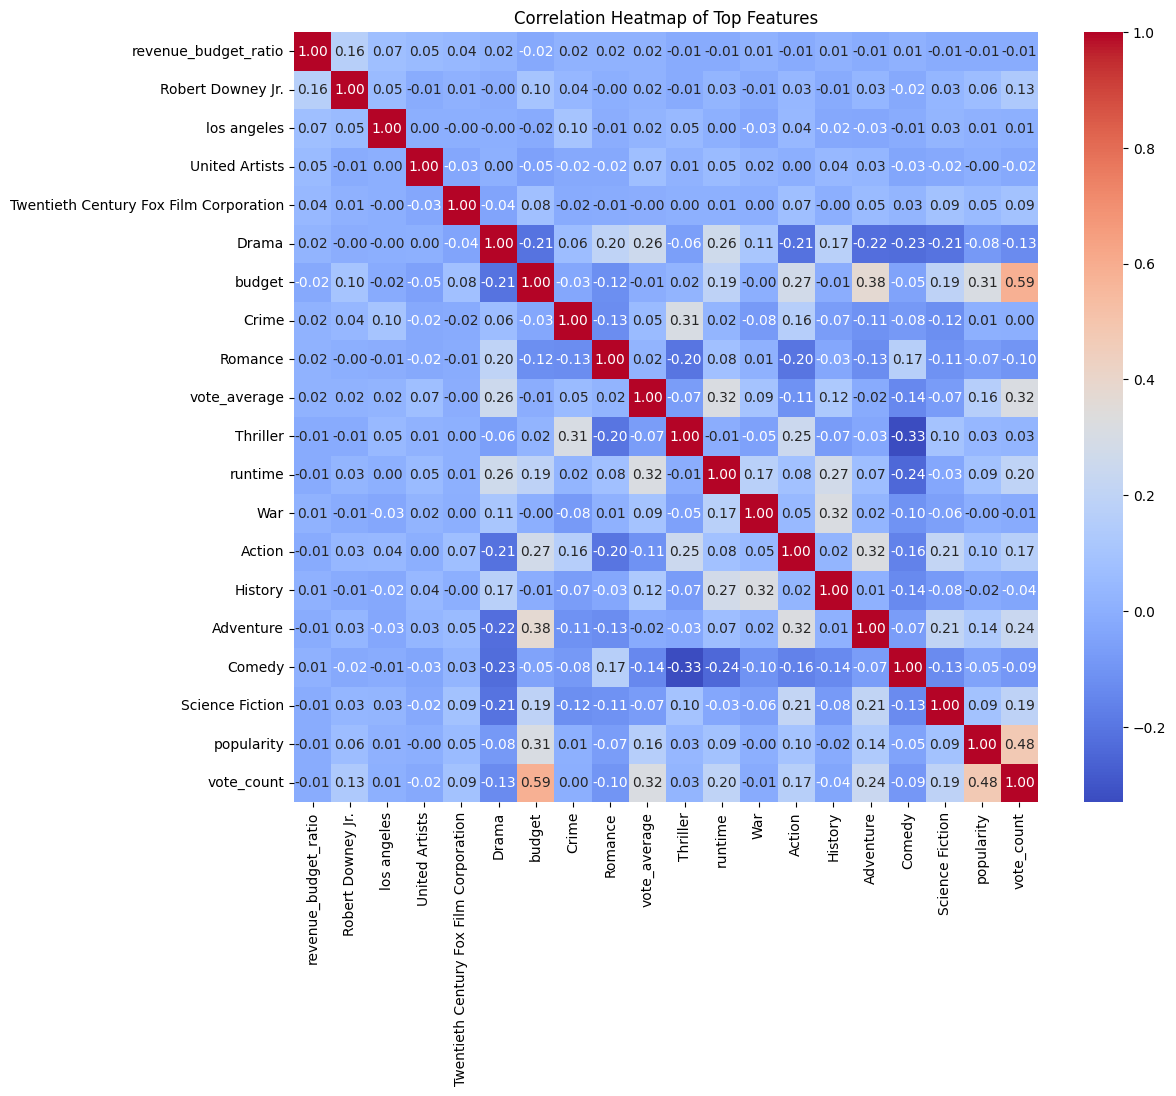

In [22]:
# Plot heatmap of correlations
import seaborn as sns
import matplotlib.pyplot as plt

# Select top features
top_features = correlations.abs().sort_values(ascending=False).head(20).index.tolist()

plt.figure(figsize=(12,10))
sns.heatmap(df[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Top Features')
plt.show()